In [1]:
import os
import sys
sys.path.append("./models")
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import torch
import torch.nn.functional as F

# === LLaVA Core Imports ===

# Import constants that define special tokens used by the LLaVA model.
# IMAGE_TOKEN_INDEX: An index (e.g., -200) used to represent the position of an image in the input sequence.
# DEFAULT_IMAGE_TOKEN: The actual string token (e.g., "<image>") that represents the image in the text prompt.
# DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN: Optional tokens ("<im_start>", "<im_end>") to wrap around the image token,
# used by some model versions to better delineate image data.
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN

# Import conversation templates and separator styles.
# LLaVA supports various base models (like Vicuna, Llama-2), each with a specific chat format.
# `conv_templates` is a dictionary of these predefined formats (e.g., roles, separator tokens)
# to ensure the prompt is structured correctly for the chosen model.
from llava.conversation import conv_templates, SeparatorStyle

# Import the main function for loading a pre-trained LLaVA model.
# This is a high-level utility that handles model configuration, quantization (4-bit/8-bit),
# and loading of both the language model and the vision tower.
from llava.model.builder import load_pretrained_model

# Import a utility to disable default PyTorch tensor initialization.
# This can speed up model loading by preventing unnecessary random initializations of weights
# before the actual pre-trained weights are loaded.
from llava.utils import disable_torch_init

# Import multi-modal utility functions.
# `process_images`: The core function to preprocess images (padding, resizing, normalizing) and convert them to tensors.
# `tokenizer_image_token`: A helper to correctly format the prompt string, replacing the placeholder image token
#                          with the correct token IDs for the model's tokenizer.
# `get_model_name_from_path`: A simple utility to extract the model's name from its path or Hugging Face identifier.
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

# Import utility functions for image processing and visualization.
# `load_image`: A function to load an image from a file or URL.
# `aggregate_llm_attention`, `aggregate_vit_attention`: Functions to aggregate attention maps from the language model and vision tower.
# `heterogenous_stack`: A utility to stack attention maps from different layers.
# `show_mask_on_image`: A function to overlay attention masks on images.
from utils import (
    load_image,
    aggregate_llm_attention, aggregate_vit_attention,
    heterogenous_stack,
    show_mask_on_image
)

# Check GPU memory
if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"GPU Memory: {gpu_memory:.1f} GB")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available!")


d:\Projects\VLM-Visualizer\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU Memory: 8.0 GB
GPU Name: NVIDIA GeForce GTX 1080


In [2]:
# ===> Model Configuration for 8GB GPU

model_path = "liuhaotian/llava-v1.5-7b"

# Optimized settings for 8GB GPU
# Try 4-bit first, fallback to 8-bit if issues
load_8bit = False
load_4bit = True  # Essential for 8GB GPU

# Alternative: Use 8-bit if 4-bit causes issues
# load_8bit = True
# load_4bit = False

device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cpu":
    raise ValueError("CUDA is not available")

print(f"Loading model: {model_path}")
print(f"Using 4-bit quantization: {load_4bit}")
print(f"Using 8-bit quantization: {load_8bit}")

disable_torch_init()

# Load the model with optimized settings
model_name = get_model_name_from_path(model_path)
print(f"Model name: {model_name}")

try:
    tokenizer, model, image_processor, context_len = load_pretrained_model(
        model_path,
        None,  # model_base
        model_name,
        load_8bit,
        load_4bit,
        device=device,
        device_map="auto",  # Automatically distribute across GPU/CPU
    )
    print("✅ Model loaded successfully!")

except Exception as e:
    print(f"❌ Error with current settings: {e}")
    print("🔄 Trying alternative approach with 8-bit quantization...")

    # Fallback to 8-bit quantization
    tokenizer, model, image_processor, context_len = load_pretrained_model(
        model_path,
        None,  # model_base
        model_name,
        load_8bit=True,
        load_4bit=False,
        device=device,
        device_map="auto",
    )
    print("✅ Model loaded successfully with 8-bit quantization!")

# Check actual GPU memory usage
if torch.cuda.is_available():
    memory_used = torch.cuda.memory_allocated(0) / 1024**3
    memory_total = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"GPU Memory Used: {memory_used:.2f} GB / {memory_total:.1f} GB ({memory_used/memory_total*100:.1f}%)")


Loading model: liuhaotian/llava-v1.5-7b
Using 4-bit quantization: True
Using 8-bit quantization: False
Model name: llava-v1.5-7b


You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████| 2/2 [00:17<00:00,  8.72s/it]


✅ Model loaded successfully!
GPU Memory Used: 4.77 GB / 8.0 GB (59.6%)


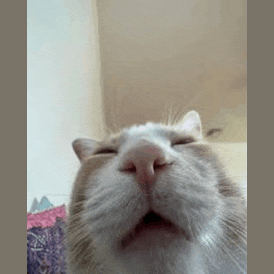

What is the breed of the cat? why?
{'input_ids': [1, 1724, 338, 278, 2078, 287, 310, 278, 6635, 29973, 2020, 29973], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
tensor([[    1,  3148,  1001, 29901, 29871,  -200, 29871,    13,  5618,   338,
           278,  2078,   287,   310,   278,  6635, 29973,  2020, 29973,   319,
          1799,  9047, 13566, 29901]], device='cuda:0')


In [11]:
# ===> specify the image path or url and the prompt text
# image_path_or_url = "https://github.com/open-compass/MMBench/blob/main/samples/MMBench/1.jpg?raw=true"
# prompt_text = "What python code can be used to generate the output in the image?"
# prompt_text = "What is the third word in the image?"
image_path_or_url = "assets/cat.png"
prompt_text = "What is the breed of the cat? why?"

################################################
# preparation for the generation
# unlikely that you need to change anything here
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

conv = conv_templates[conv_mode].copy()
if "mpt" in model_name.lower():
    roles = ('user', 'assistant')
else:
    roles = conv.roles

image = load_image(image_path_or_url)
image_tensor, images = process_images([image], image_processor, model.config)
image = images[0]
image_size = image.size
if type(image_tensor) is list:
    image_tensor = [image.to(model.device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(model.device, dtype=torch.float16)

if model.config.mm_use_im_start_end:
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + prompt_text
else:
    inp = DEFAULT_IMAGE_TOKEN + '\n' + prompt_text

conv.append_message(conv.roles[0], inp)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()
# manually removing the system prompt here
# otherwise most attention will be somehow put on the system prompt
prompt = prompt.replace(
    "A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. ",
    ""
)

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(model.device)
################################################

display(image)
print(prompt_text)
print(tokenizer(prompt_text))
print(input_ids)


"What python code..." 

    ↓
"USER: \<image\>\nWhat python code... ASSISTANT:"

    ↓
[1, 3148, 1001, 29901, 29871, -200, 29871, 13, 5618, ...]

In [12]:
# generate the response
with torch.inference_mode():
    outputs = model.generate(
        input_ids,
        images=image_tensor,
        image_sizes=[image_size],
        do_sample=False,
        max_new_tokens=512,
        use_cache=True,
        return_dict_in_generate=True,
        output_attentions=True, # expose the attention weights
    )

text = tokenizer.decode(outputs["sequences"][0]).strip()
print(text)

The cat in the image is a tabby cat. Tabby cats are easily recognizable due to their distinctive coat patterns, which typically include a mix of brown, black, and white fur. The cat's facial features, such as its whiskers, nose, and eyes, are also visible in the close-up photo. The close-up nature of the image allows for a clear view of the cat's unique features, which are characteristic of tabby cats.</s>


## Definition of Multi-headed Attention

![img](assets/llm.png)
^ https://www.youtube.com/watch?v=0VLAoVGf_74

**Definition 1** (Scaled Dot-Product Attention). Let
$$
\mathbf{Q} \in \mathbb{R}^{n_q \times d_k}, \quad \mathbf{K} \in \mathbb{R}^{n_k \times d_k}, \quad \mathbf{V} \in \mathbb{R}^{n_k \times d_v},
$$
where $n_q$ is the number of queries, $n_k$ the number of keys/values, $d_k$ the query/key dimension, and $d_v$ the value dimension. Scaled dot-product attention is
$$
\text{Attn}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_k}}\right) \mathbf{V} \in \mathbb{R}^{n_q \times d_v},
$$
with $\text{softmax}(\mathbf{Z})_{ij} = e^{Z_{ij}} / \sum_j e^{Z_{ij}}$ applied row-wise.

**Definition 2** (Multi-Head Attention). Given a model dimension $d_{\text{model}}$ and $h$ heads, set $d_k = d_v = d_{\text{model}}/h$. For each head $i = 1, \ldots, h$ introduce learnable projection matrices
$$
\mathbf{W}_i^Q, \mathbf{W}_i^K \in \mathbb{R}^{d_{\text{model}} \times d_k}, \quad \mathbf{W}_i^V \in \mathbb{R}^{d_{\text{model}} \times d_v}.
$$
For an input sequence $\mathbf{X} \in \mathbb{R}^{n \times d_{\text{model}}}$,
$$
\mathbf{H}_i = \text{Attn}(\mathbf{X}\mathbf{W}_i^Q, \mathbf{X}\mathbf{W}_i^K, \mathbf{X}\mathbf{W}_i^V) \in \mathbb{R}^{n \times d_v}.
$$
Concatenate the heads
$$
\mathbf{H}_{\text{cat}} = \text{Concat}(\mathbf{H}_1, \ldots, \mathbf{H}_h) \in \mathbb{R}^{n \times hd_v} = \mathbb{R}^{n \times d_{\text{model}}},
$$
then apply the output projection matrix $\mathbf{W}^O \in \mathbb{R}^{d_{\text{model}} \times d_{\text{model}}}$:
$$
\text{MHA}(\mathbf{X}) = \mathbf{H}_{\text{cat}} \mathbf{W}^O \in \mathbb{R}^{n \times d_{\text{model}}}.
$$

## Aggregating Attention
### LLM Attention

Below we are aggregating LLM's attention aross $H$ heads and $L$ layers (simply averaging them). See the `aggregate_llm_attention` in `utils.py` for details.

**Definition 3** (Averaging across Heads). For each layer $l$, we first take the average over all attention heads $H$. We only care about the attention paid to the new token being generated, which corresponds to the last row of the attention matrix.

$$
\tilde{\mathbf{a}}_{gen,k}^{(l)} = \frac{1}{H} \sum_{h=1}^{H} \mathbf{a}_{N_{\text{prompt}}+k-1}^{(l,h)}
$$

Here, $\tilde{\mathbf{a}}_{gen,k}^{(l)} \in \mathbb{R}^{N_{\text{prompt}}+k}$ is the layer-$l$, per-generated-token attention vector after averaging across heads.

**Definition 4** (Averaging across Layers). Finally, we average over all layers $L$ to obtain the final aggregated attention vector.

$$
\overline{\mathbf{a}}_{gen,k} = \frac{1}{L} \sum_{l=0}^{L-1} \tilde{\mathbf{a}}_{gen,k}^{(l)}
$$

In [13]:
# constructing the llm attention matrix
aggregated_prompt_attention = []
for i, layer in enumerate(outputs["attentions"][0]):
    layer_attns = layer.squeeze(0)
    attns_per_head = layer_attns.mean(dim=0)
    cur = attns_per_head[:-1].cpu().clone()
    # following the practice in `aggregate_llm_attention`
    # we are zeroing out the attention to the first <bos> token
    # for the first row `cur[0]` (corresponding to the next token after <bos>), however,
    # we don't do this because <bos> is the only token that it can attend to
    cur[1:, 0] = 0.
    cur[1:] = cur[1:] / cur[1:].sum(-1, keepdim=True)
    aggregated_prompt_attention.append(cur)
aggregated_prompt_attention = torch.stack(aggregated_prompt_attention).mean(dim=0)

# llm_attn_matrix will be of torch.Size([N, N])
# where N is the total number of input (both image and text ones) + output tokens
llm_attn_matrix = heterogenous_stack(
    [torch.tensor([1])]
    + list(aggregated_prompt_attention)
    + list(map(aggregate_llm_attention, outputs["attentions"]))
)

llm_attn_matrix.size()

torch.Size([701, 701])

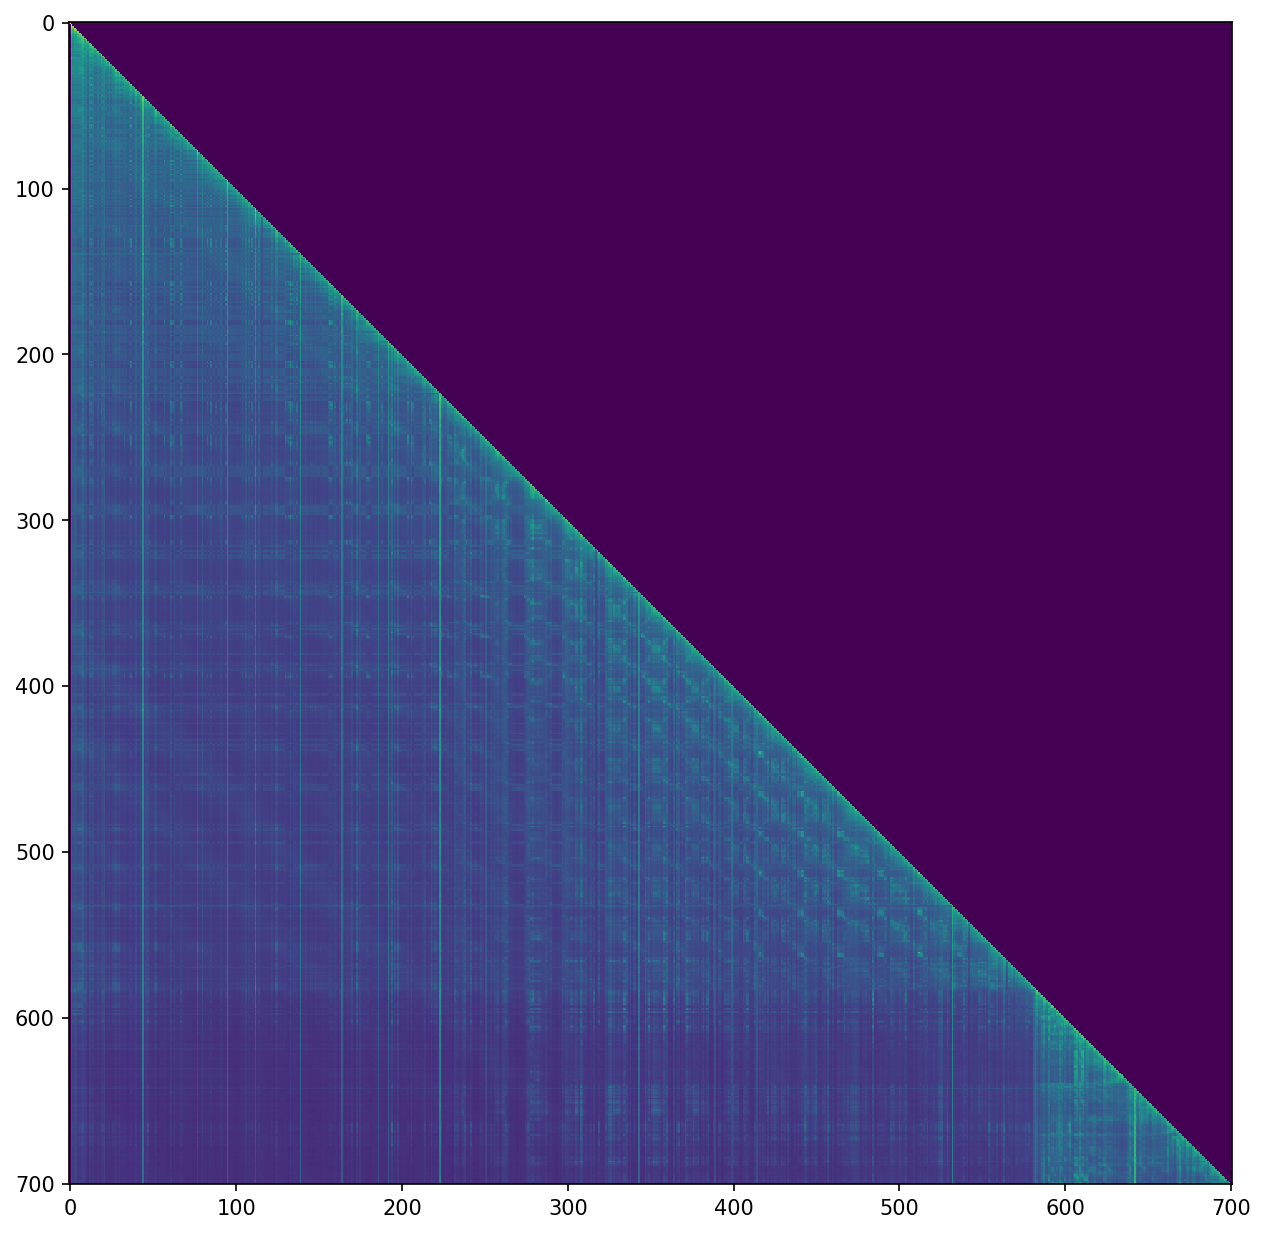

In [14]:
# visualize the llm attention matrix
# ===> adjust the gamma factor to enhance the visualization
#      higer gamma brings out more low attention values
gamma_factor = 5
enhanced_attn_m = np.power(llm_attn_matrix.numpy(), 1 / gamma_factor)

fig, ax = plt.subplots(figsize=(10, 20), dpi=150)
ax.imshow(enhanced_attn_m, vmin=enhanced_attn_m.min(), vmax=enhanced_attn_m.max(), interpolation="nearest")

### ViT Attention

[Prefix Tokens] [Image Tokens] [Suffix Tokens] [Generated Tokens]

In [15]:
# identify length or index of tokens
input_token_len = model.get_vision_tower().num_patches + len(input_ids[0]) - 1 # -1 for the <image> token
vision_token_start = len(tokenizer(prompt.split("<image>")[0], return_tensors='pt')["input_ids"][0])
vision_token_end = vision_token_start + model.get_vision_tower().num_patches
output_token_len = len(outputs["sequences"][0])
output_token_start = input_token_len
output_token_end = input_token_len + output_token_len

print(input_token_len, vision_token_start, vision_token_end, output_token_len, output_token_start, output_token_end)

599 5 581 102 599 701


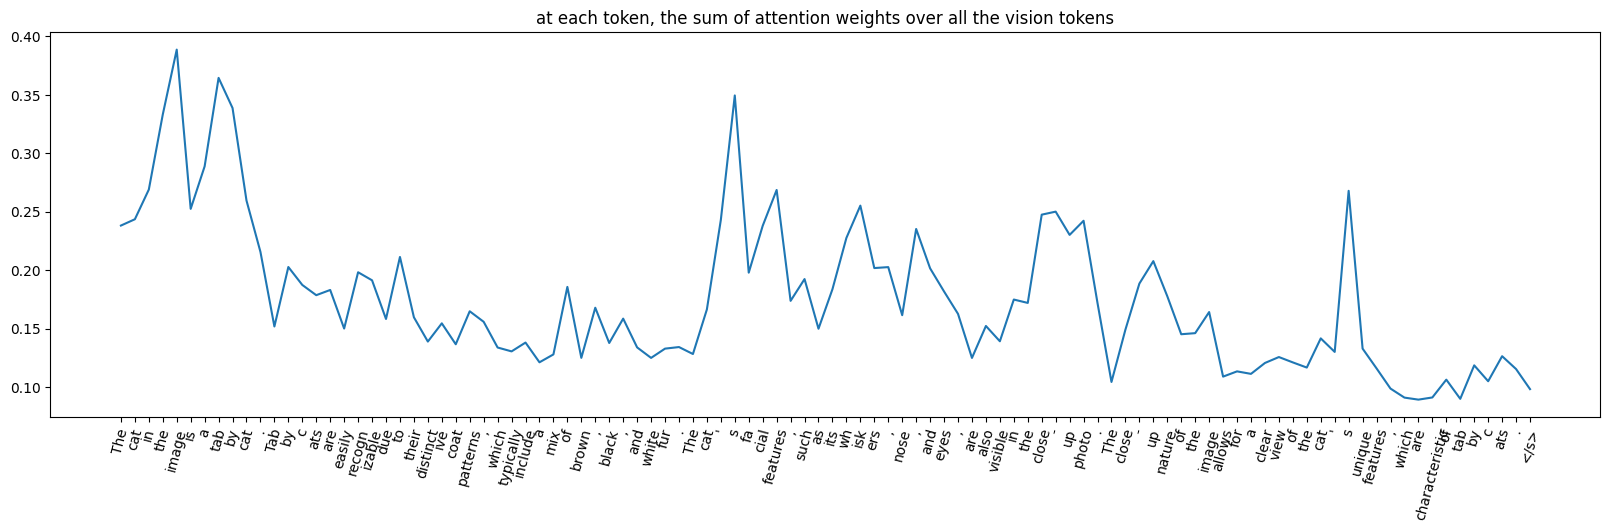

In [16]:
# look at the attention weights over the vision tokens
overall_attn_weights_over_vis_tokens = []
for i, (row, token) in enumerate(
    zip(
        llm_attn_matrix[input_token_len:],
        outputs["sequences"][0].tolist()
    )
):
    # print(
    #     i + input_token_len,
    #     f"{tokenizer.decode(token, add_special_tokens=False).strip():<15}",
    #     f"{row[vision_token_start:vision_token_end].sum().item():.4f}"
    # )

    overall_attn_weights_over_vis_tokens.append(
        row[vision_token_start:vision_token_end].sum().item()
    )

# plot the trend of attention weights over the vision tokens
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(overall_attn_weights_over_vis_tokens)
ax.set_xticks(range(len(overall_attn_weights_over_vis_tokens)))
ax.set_xticklabels(
    [tokenizer.decode(token, add_special_tokens=False).strip() for token in outputs["sequences"][0].tolist()],
    rotation=75
)
ax.set_title("at each token, the sum of attention weights over all the vision tokens");

Below we aim to visualize the attention w.r.t. the input image. First we obtain a single attention map from the vision encoder (ViT) by again averaging the attention maps across heads and layers. I have tried a supposedly more reasonable method of [attention rollout](https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py), i.e. multiplying the attention matrices over each layer, but never got sensible results. See the `aggregate_vit_attention` in `utils.py` for details.


Then, for each generated token of LLM, we compute the weighted average of the attention map of each vision token to get an aggregated attention map over the input image for that generated token. Finally we resize and overlay the attention map on the input image.

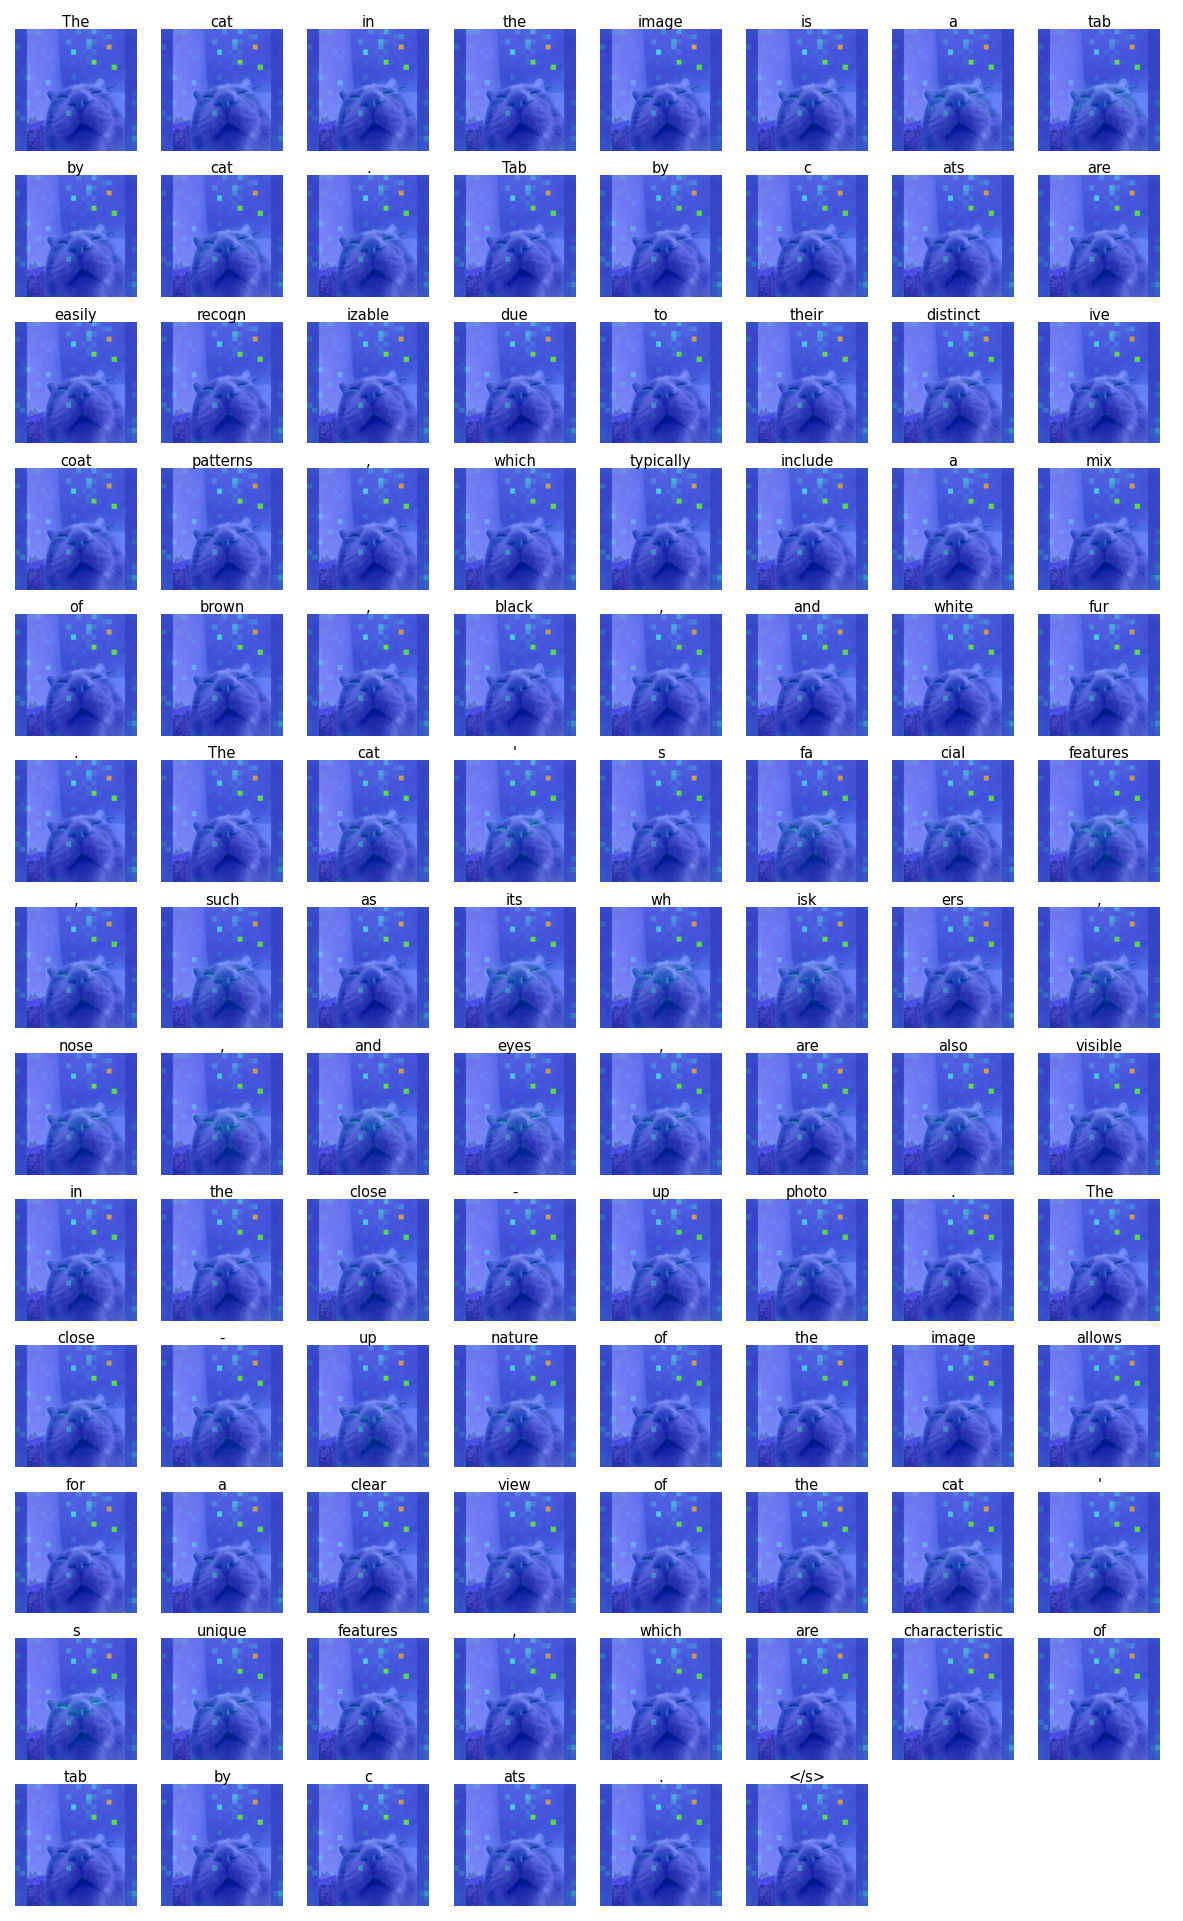

In [17]:
# connect with the vision encoder attention
# to visualize the attention over the image

# vis_attn_matrix will be of torch.Size([N, N])
# where N is the number of vision tokens/patches
# `all_prev_layers=True` will average attention from all layers until the selected layer
# otherwise only the selected layer's attention will be used
vis_attn_matrix = aggregate_vit_attention(
    model.get_vision_tower().image_attentions,
    select_layer=model.get_vision_tower().select_layer,
    all_prev_layers=True
)
grid_size = model.get_vision_tower().num_patches_per_side

num_image_per_row = 8
image_ratio = image_size[0] / image_size[1]
num_rows = output_token_len // num_image_per_row + (1 if output_token_len % num_image_per_row != 0 else 0)
fig, axes = plt.subplots(
    num_rows, num_image_per_row,
    figsize=(10, (10 / num_image_per_row) * image_ratio * num_rows),
    dpi=150
)
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# whether visualize the attention heatmap or
# the image with the attention heatmap overlayed
vis_overlayed_with_attn = True

output_token_inds = list(range(output_token_start, output_token_end))
for i, ax in enumerate(axes.flatten()):
    if i >= output_token_len:
        ax.axis("off")
        continue

    target_token_ind = output_token_inds[i]
    attn_weights_over_vis_tokens = llm_attn_matrix[target_token_ind][vision_token_start:vision_token_end]
    attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.sum()

    attn_over_image = []
    for weight, vis_attn in zip(attn_weights_over_vis_tokens, vis_attn_matrix):
        vis_attn = vis_attn.reshape(grid_size, grid_size)
        # vis_attn = vis_attn / vis_attn.max()
        attn_over_image.append(vis_attn * weight)
    attn_over_image = torch.stack(attn_over_image).sum(dim=0)
    attn_over_image = attn_over_image / attn_over_image.max()

    attn_over_image = F.interpolate(
        attn_over_image.unsqueeze(0).unsqueeze(0),
        size=image.size,
        mode='nearest',
        # mode='bicubic', align_corners=False
    ).squeeze()

    np_img = np.array(image)[:, :, ::-1]
    img_with_attn, heatmap = show_mask_on_image(np_img, attn_over_image.numpy())
    ax.imshow(heatmap if not vis_overlayed_with_attn else img_with_attn)
    ax.set_title(
        tokenizer.decode(outputs["sequences"][0][i], add_special_tokens=False).strip(),
        fontsize=7,
        pad=1
    )
    ax.axis("off");

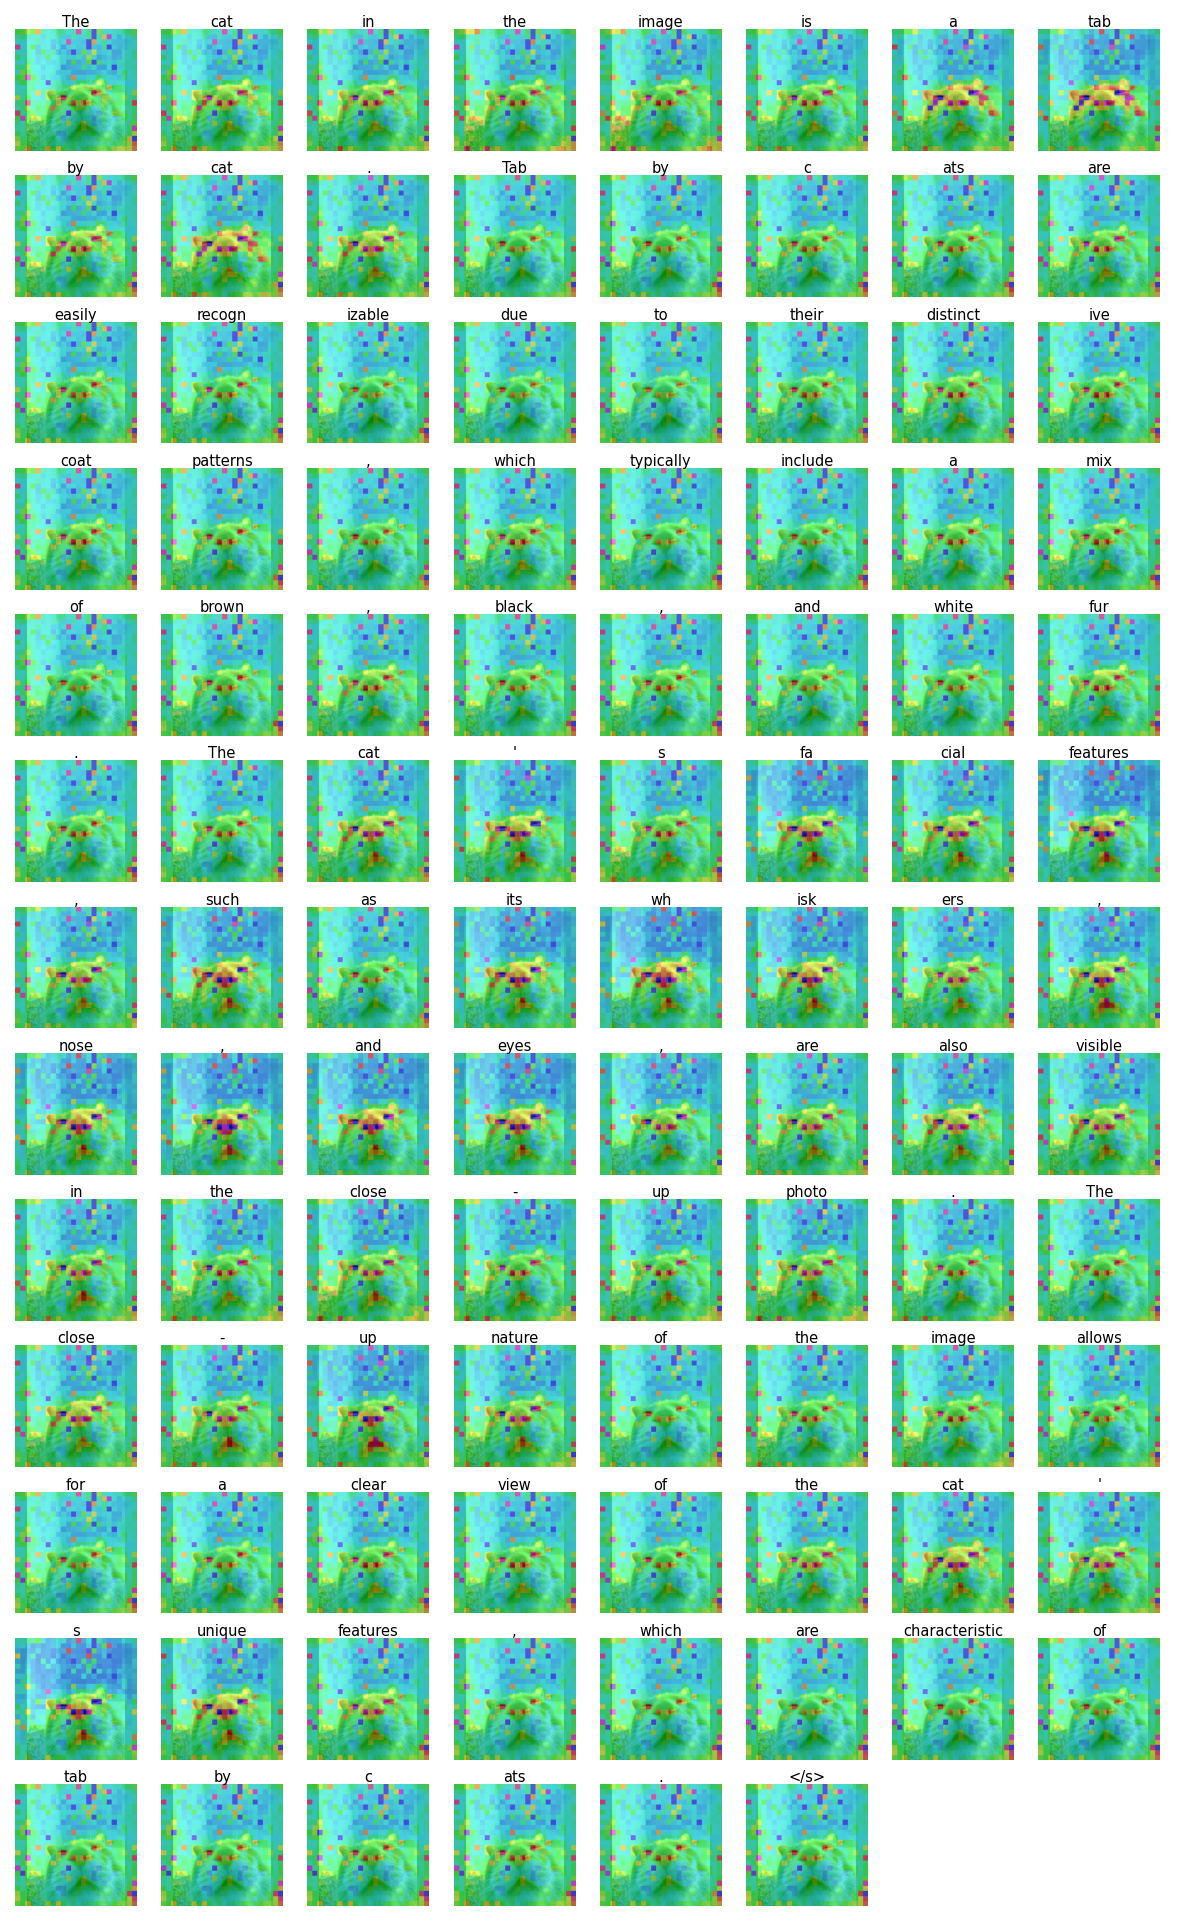

In [18]:
vis_attn_matrix = aggregate_vit_attention(
    model.get_vision_tower().image_attentions,
    select_layer=model.get_vision_tower().select_layer,
    all_prev_layers=True
)
grid_size = model.get_vision_tower().num_patches_per_side

num_image_per_row = 8
image_ratio = image_size[0] / image_size[1]
num_rows = output_token_len // num_image_per_row + (1 if output_token_len % num_image_per_row != 0 else 0)
fig, axes = plt.subplots(
    num_rows, num_image_per_row,
    figsize=(10, (10 / num_image_per_row) * image_ratio * num_rows),
    dpi=150
)
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# whether visualize the attention heatmap or
# the image with the attention heatmap overlayed
vis_overlayed_with_attn = True

output_token_inds = list(range(output_token_start, output_token_end))
for i, ax in enumerate(axes.flatten()):
    if i >= output_token_len:
        ax.axis("off")
        continue

    target_token_ind = output_token_inds[i]
    attn_weights_over_vis_tokens = llm_attn_matrix[target_token_ind][vision_token_start:vision_token_end]
    attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.sum()

    attn_over_image = []
    for weight, vis_attn in zip(attn_weights_over_vis_tokens, vis_attn_matrix):
        vis_attn = vis_attn.reshape(grid_size, grid_size)
        # vis_attn = vis_attn / vis_attn.max()
        attn_over_image.append(vis_attn * weight)
    attn_over_image = torch.stack(attn_over_image).sum(dim=0)

    # Flatten the attention map to find the top K values
    attn_map_flat = attn_over_image.flatten()

    if len(attn_map_flat) > 10:
        _, top_k_indices = torch.topk(attn_map_flat, 10)

        modified_attn_map_flat = attn_map_flat.clone()
        modified_attn_map_flat[top_k_indices] = 0

        attn_over_image = modified_attn_map_flat.reshape(grid_size, grid_size)

    # Normalize and add a small epsilon to avoid division by zero if all patches are zeroed out
    attn_over_image = attn_over_image / (attn_over_image.max() + 1e-8)

    attn_over_image = F.interpolate(
        attn_over_image.unsqueeze(0).unsqueeze(0),
        size=image.size,
        mode='nearest',
        # mode='bicubic', align_corners=False
    ).squeeze()

    np_img = np.array(image)[:, :, ::-1]
    img_with_attn, heatmap = show_mask_on_image(np_img, attn_over_image.numpy())
    ax.imshow(heatmap if not vis_overlayed_with_attn else img_with_attn)
    ax.set_title(
        tokenizer.decode(outputs["sequences"][0][i], add_special_tokens=False).strip(),
        fontsize=7,
        pad=1
    )
    ax.axis("off");